In [1]:
from data import *
import utils
import warnings
warnings.filterwarnings("ignore")

path = "Data/Dataset"
recs = Recordings(path)

100%|██████████| 52/52 [05:21<00:00,  6.17s/it]


In [2]:
recs.calc_events(force_calculation=False)

In [3]:
final_rounds = recs[0].get_final_rounds("nod").Round.to_numpy()
scene_info = recs[0]["nod"]["SceneData"]
scene_info.loc[scene_info.Round.isin(final_rounds)]

,Timestamp,EyeDataTimestamp,Main CameraPosX,Main CameraPosY,Main CameraPosZ,Main CameraForwardX,Main CameraForwardY,Main CameraForwardZ,Main CameraRotX,Main CameraRotY,...,robot5TargetForwardZ,robot5TargetRotX,robot5TargetRotY,robot5TargetRotZ,robot5TargetRotW,robot5TargetMT,FixatedObject,Round,Points,Msg
13807,1440.254,1728049484389,-0.201822,1.577620,-0.054685,-0.277351,-0.116038,-0.953736,-0.032885,0.987819,...,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,False,robot1,2,0,StartGame
13808,1440.266,1728049484400,-0.201374,1.577447,-0.053925,-0.277638,-0.117661,-0.953453,-0.033175,0.987738,...,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,False,robot1,2,0,NaN
13809,1440.276,1728049484412,-0.200872,1.577266,-0.053138,-0.278319,-0.119488,-0.953027,-0.033627,0.987615,...,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,False,robot1,2,0,NaN
13810,1440.288,1728049484422,-0.200410,1.577129,-0.052358,-0.278822,-0.121106,-0.952676,-0.034083,0.987510,...,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,False,robot1,2,0,NaN
13811,1440.299,1728049484433,-0.200009,1.576909,-0.051579,-0.280176,-0.122422,-0.952110,-0.034538,0.987351,...,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,False,robot1,2,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42672,1760.844,1728049804982,-0.241294,1.489837,-0.208321,-0.020190,-0.622166,-0.782625,-0.003017,0.944089,...,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,False,NoObjectFound,11,133,NaN
42673,1760.855,1728049804990,-0.241822,1.489839,-0.209399,-0.019598,-0.621227,-0.783386,-0.003379,0.944289,...,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,False,NoObjectFound,11,133,NaN
42674,1760.866,1728049805002,-0.242255,1.489996,-0.210571,-0.019236,-0.620373,-0.784071,-0.003488,0.944470,...,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,False,NoObjectFound,11,133,NaN
42675,1760.878,1728049805012,-0.242778,1.490059,-0.211676,-0.019132,-0.618955,-0.785194,-0.003397,0.944767,...,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,False,NoObjectFound,11,133,NaN


In [8]:
cond = "nod"
rec  = recs[2]
final_rounds = rec.get_final_rounds(cond).Round.to_numpy()
gaze = rec[cond]["Gaze"]
scene = rec[cond]["SceneData"]
scene = scene.loc[scene.Round.isin(final_rounds)]
scene_infos = scene.loc[scene.Msg.astype(str).apply(lambda x: "target selected" in x), ["Msg", "EyeDataTimestamp"]]
scene_infos

,Msg,EyeDataTimestamp
14366,Correct target selected,1728307858643
14584,Correct target selected,1728307861062
14800,Correct target selected,1728307863461
15018,Correct target selected,1728307865882
15360,Correct target selected,1728307869681
...,...,...
41308,Correct target selected,1728308157863
41547,Correct target selected,1728308160517
41806,Correct target selected,1728308163395
42151,Correct target selected,1728308167226


In [9]:
savepath = "Data/Dataset_Prepare"
# cond = "nod"

save=True

frame_count = 44
time_before = 300
time_after = 200
fps=90

# rec = recs["Pat020"]
for cond in Recording.conditions:
    res = {"Complete": {"All": 0, "Correct": 0, "Incorrect": 0}}
    angles = {"Correct": list(), "Incorrect": list()}
    pat_name = {"Correct": list(), "Incorrect": list()}
    for rec in recs:
        final_rounds = rec.get_final_rounds(cond).Round.to_numpy()
        gaze = rec[cond]["Gaze"] if fps==90 else rec[cond]["Gaze120"]
        scene = rec[cond]["SceneData"]
        scene = scene.loc[scene.Round.isin(final_rounds)]
        scene_infos = scene.loc[scene.Msg.astype(str).apply(lambda x: "target selected" in x), ["Msg", "EyeDataTimestamp"]]

        res[rec.name] = {"All": 0, "Correct": 0, "Incorrect": 0}
        for _, row in scene_infos.iterrows():
            msg = row["Msg"]
            t = row["EyeDataTimestamp"]
            gaze_use = gaze.loc[(gaze["System Timestamp"] > t - time_before) & (gaze["System Timestamp"] < t+time_after)]
            for k in ["Complete", rec.name]:
                res[k]["All"] += 1
                kind = "Correct" if "Correct" in msg else "Incorrect"
                if len(gaze_use) < frame_count:
                    res[k][kind] += 1
                else:
                    if k == "Complete":
                        gvs = gaze_use[["Local Gaze Direction %s" % x for x in ["X", "Y", "Z"]]].to_numpy()
                        # angles_rec = [utils.angle_between(np.array([0, 0, 1]), x) for x in gvs[:83]]
                        angles_rec = [utils.angle_between(x, y) for x, y in zip(gvs[:(frame_count-1)], gvs[1:frame_count])]
                        angles[kind].append(angles_rec)
                        pat_name[kind].append(rec.name)
    

    # key All: How many recordings exists in total
    # key Correct/Incorrect: How many correct/incorrect recordings have less than frame_count frames
    for k in res:
        print("="*80)
        print(k)
        for kk in res[k]:
            print(f"{kk}: {res[k][kk]}")
        print()

    if save:
        for k in ["Correct", "Incorrect"]:
            a = np.array(angles[k])
            p = np.array(pat_name[k])
            np.save(os.path.join(savepath, f"angles_fps{fps}_{cond}_{k}_f{frame_count}_b{time_before}_a{time_after}_finalRounds.npy"), a)
            np.save(os.path.join(savepath, f"names_fps{fps}_{cond}_{k}_f{frame_count}_b{time_before}_a{time_after}_finalRounds.npy"), p)

Complete
All: 5091
Correct: 533
Incorrect: 74

Pat001
All: 101
Correct: 11
Incorrect: 3

Pat002
All: 99
Correct: 7
Incorrect: 0

Pat003
All: 101
Correct: 8
Incorrect: 0

Pat004
All: 103
Correct: 2
Incorrect: 1

Pat005
All: 103
Correct: 14
Incorrect: 8

Pat006
All: 105
Correct: 4
Incorrect: 0

Pat007
All: 69
Correct: 6
Incorrect: 0

Pat008
All: 107
Correct: 13
Incorrect: 2

Pat009
All: 90
Correct: 5
Incorrect: 1

Pat010
All: 98
Correct: 3
Incorrect: 0

Pat011
All: 105
Correct: 5
Incorrect: 1

Pat012
All: 102
Correct: 1
Incorrect: 2

Pat013
All: 101
Correct: 10
Incorrect: 5

Pat014
All: 104
Correct: 7
Incorrect: 0

Pat015
All: 103
Correct: 4
Incorrect: 0

Pat016
All: 103
Correct: 6
Incorrect: 1

Pat017
All: 93
Correct: 6
Incorrect: 0

Pat018
All: 78
Correct: 13
Incorrect: 0

Pat019
All: 91
Correct: 5
Incorrect: 5

Pat020
All: 101
Correct: 12
Incorrect: 1

Pat021
All: 79
Correct: 9
Incorrect: 0

Pat022
All: 103
Correct: 26
Incorrect: 2

Pat023
All: 86
Correct: 7
Incorrect: 0

Pat024
All: 

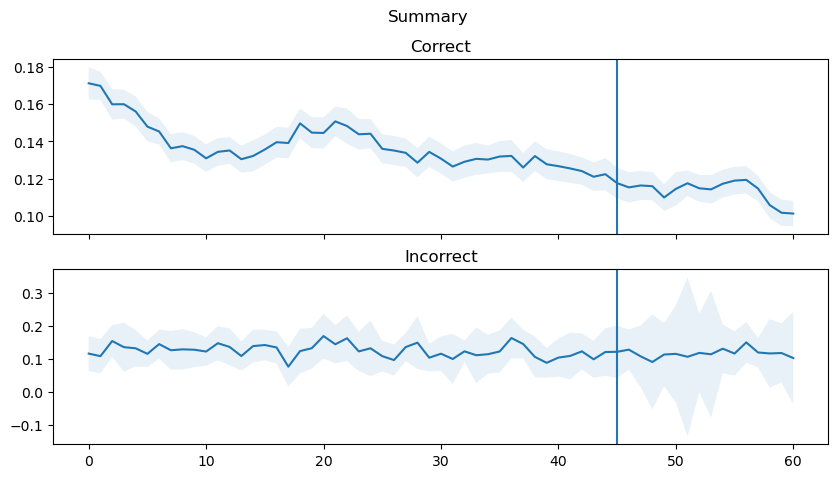

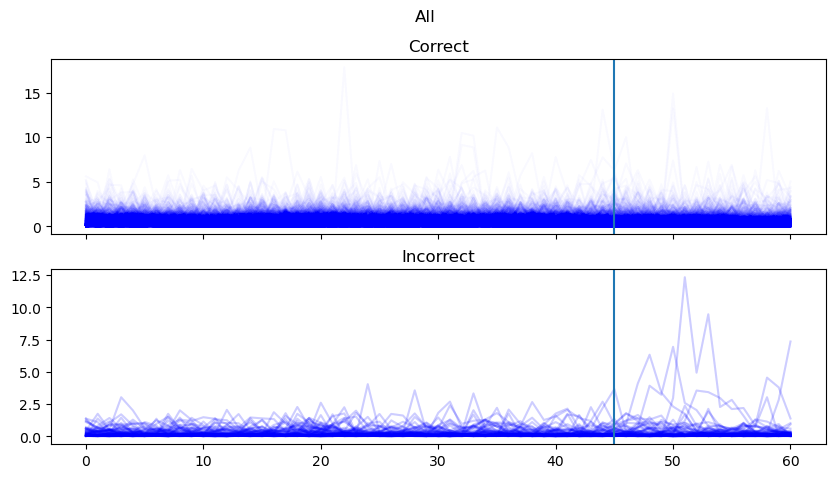

In [ ]:
import matplotlib.pyplot as plt

fig_summary, axs_summary = plt.subplots(2, sharex=True, figsize=(10,5))



for i, kind in enumerate(["Correct", "Incorrect"]):
    v = np.array(angles[kind])
    n = v.shape[0]
    means = np.median(v, axis=0)
    stds = np.std(v, axis=0)
    stds = 1.96*stds/np.sqrt(n)
    x = np.arange(len(means))
    axs_summary[i].plot(x, means)
    axs_summary[i].fill_between(x, means-stds, means+stds, alpha=.1)
    axs_summary[i].set_title(kind)
    axs_summary[i].axvline(x=45)
    means
fig_summary.suptitle("Summary")
plt.show()

fig_all, axs_all = plt.subplots(2, sharex=True, figsize=(10, 5))
alpha = {"Correct": .01, "Incorrect": 0.1}

for i, kind in enumerate(["Correct", "Incorrect"]):
    x = np.arange(len(angles[kind][0]))
    for values in angles[kind]:
        axs_all[i].plot(x, values, alpha=alpha[kind], color="blue")
    axs_all[i].axvline(x=45)
    axs_all[i].set_title(kind)
fig_all.suptitle("All")
plt.show()          

# import pandas as pd
# pd.DataFrame(res).transpose()

In [ ]:
import torch

n = int(0.7 * len(angles["Correct"]))
train_data = torch.tensor(angles["Correct"][:n]).type(torch.float)[:, :, None]
test_correct = torch.tensor(angles["Correct"][n:]).type(torch.float)[:, :, None]
test_incorrect = torch.tensor(angles["Incorrect"]).type(torch.float)[:, :, None]

print(f"{train_data.shape=}, {test_correct.shape=}, {test_incorrect.shape=}")

train_data.shape=torch.Size([7984, 82, 1]), test_correct.shape=torch.Size([3422, 82, 1]), test_incorrect.shape=torch.Size([160, 82, 1])


0.8684979544126242 0.1125


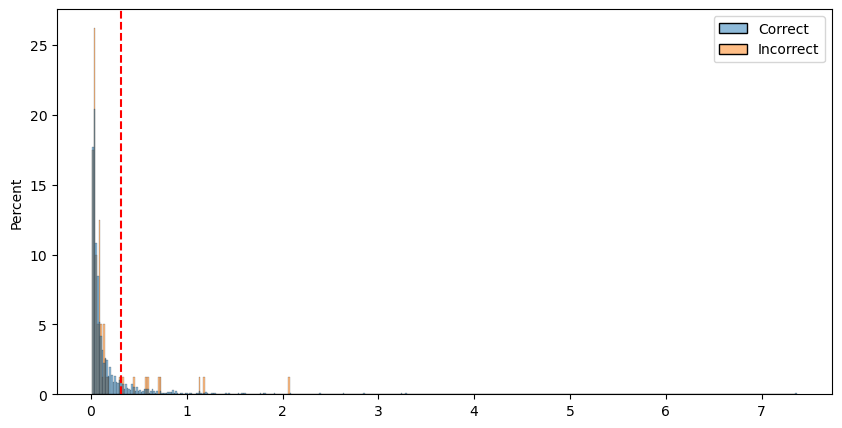

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
baseline = train_data.mean(axis=0)
error_baseline_train = torch.mean((train_data - baseline)**2, dim=(1, 2))
th = np.percentile(error_baseline_train.numpy(), 95)
error_baseline_correct = torch.mean((test_correct - baseline)**2, dim=(1, 2))
error_baseline_incorrect = torch.mean((test_incorrect - baseline)**2, dim=(1, 2))
correct_class = error_baseline_correct < th
incorrect_class = error_baseline_incorrect > th
print(np.mean(correct_class.numpy()), np.mean(incorrect_class.numpy()))

fig, ax = plt.subplots(figsize=(10, 5))

sns.histplot({"Correct": error_baseline_correct.numpy(), "Incorrect": error_baseline_incorrect.numpy()},
             multiple="layer", common_norm=False, stat="percent", ax=ax)
ax.axvline(th, color='red', linestyle='--', label="Threshold")
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

class LSTMAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_layers=1):
        super(LSTMAutoencoder, self).__init__()
        
        # Encoder LSTM
        self.encoder_lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.encoder_fc = nn.Linear(hidden_dim, latent_dim)
        
        # Decoder LSTM
        self.decoder_fc = nn.Linear(latent_dim, hidden_dim)
        self.decoder_lstm = nn.LSTM(hidden_dim, input_dim, num_layers, batch_first=True)
    
    def forward(self, x):
        # Encode
        _, (hidden, _) = self.encoder_lstm(x)
        latent = self.encoder_fc(hidden[-1])
        
        # Decode
        hidden = self.decoder_fc(latent).unsqueeze(0)
        output, _ = self.decoder_lstm(hidden.repeat(x.size(1), 1, 1).permute(1, 0, 2))
        
        return output


In [ ]:
from tqdm import trange
#  Hyperparameters
input_dim = 1       # Number of features (for univariate time series)
hidden_dim = 64     # Number of hidden units in LSTM layers
latent_dim = 16     # Size of the latent vector
num_layers = 1     # Number of LSTM layers
learning_rate = 1e-3
num_epochs = 30

# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device = torch.device("cpu")
# Instantiate model, define loss and optimizer
model = LSTMAutoencoder(input_dim, hidden_dim, latent_dim, num_layers).to(device)
criterion = nn.MSELoss()  # Mean Squared Error for reconstruction loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Dummy training data (replace with your own time series)
# Shape: (batch_size, sequence_length, input_dim)
# train_data = torch.randn(100, 30, input_dim)  # 100 sequences of 30 time steps

train_data = train_data.to(device)

# Training loop
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    output = model(train_data)
    
    # Compute reconstruction loss
    loss = criterion(output, train_data)
    loss.backward()
    optimizer.step()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


Epoch [1/200], Loss: 0.3307
Epoch [2/200], Loss: 0.3038
Epoch [3/200], Loss: 0.2801
Epoch [4/200], Loss: 0.2593
Epoch [5/200], Loss: 0.2409
Epoch [6/200], Loss: 0.2246
Epoch [7/200], Loss: 0.2101
Epoch [8/200], Loss: 0.1973
Epoch [9/200], Loss: 0.1859
Epoch [10/200], Loss: 0.1758
Epoch [11/200], Loss: 0.1670
Epoch [12/200], Loss: 0.1593
Epoch [13/200], Loss: 0.1526
Epoch [14/200], Loss: 0.1469
Epoch [15/200], Loss: 0.1422
Epoch [16/200], Loss: 0.1384
Epoch [17/200], Loss: 0.1353
Epoch [18/200], Loss: 0.1328
Epoch [19/200], Loss: 0.1307
Epoch [20/200], Loss: 0.1288
Epoch [21/200], Loss: 0.1270
Epoch [22/200], Loss: 0.1251
Epoch [23/200], Loss: 0.1230
Epoch [24/200], Loss: 0.1209
Epoch [25/200], Loss: 0.1187
Epoch [26/200], Loss: 0.1164
Epoch [27/200], Loss: 0.1142
Epoch [28/200], Loss: 0.1122
Epoch [29/200], Loss: 0.1104
Epoch [30/200], Loss: 0.1090
Epoch [31/200], Loss: 0.1080
Epoch [32/200], Loss: 0.1075
Epoch [33/200], Loss: 0.1076
Epoch [34/200], Loss: 0.1081
Epoch [35/200], Loss: 0

In [ ]:
# Dummy test data (mix of normal and anomalous sequences)
# test_data = torch.randn(20, 30, input_dim)  # Replace with your test dataset



# Set model to evaluation mode
model.eval()

# Compute reconstruction errors
with torch.no_grad():
    reconstructed_train = model(train_data)
    mse_error_train = torch.mean((reconstructed_train - train_data)**2, dim=(1, 2))
    reconstructed_correct = model(test_correct)
    mse_error_correct = torch.mean((reconstructed_correct - test_correct) ** 2, dim=(1, 2))  # Mean error per sequence
    reconstructed_incorrect = model(test_incorrect)
    mse_error_incorrect = torch.mean((reconstructed_incorrect - test_incorrect) ** 2, dim=(1, 2))

# Set a threshold based on training or validation errors (e.g., 95th percentile)


In [ ]:
mse_error_incorrect.shape

torch.Size([160])

In [ ]:
th = np.percentile(mse_error_train.numpy(), 95)

correct_class = mse_error_correct < th
incorrect_class = mse_error_incorrect > th
print(np.mean(correct_class.numpy()), np.mean(incorrect_class.numpy()))

0.864406779661017 0.0875


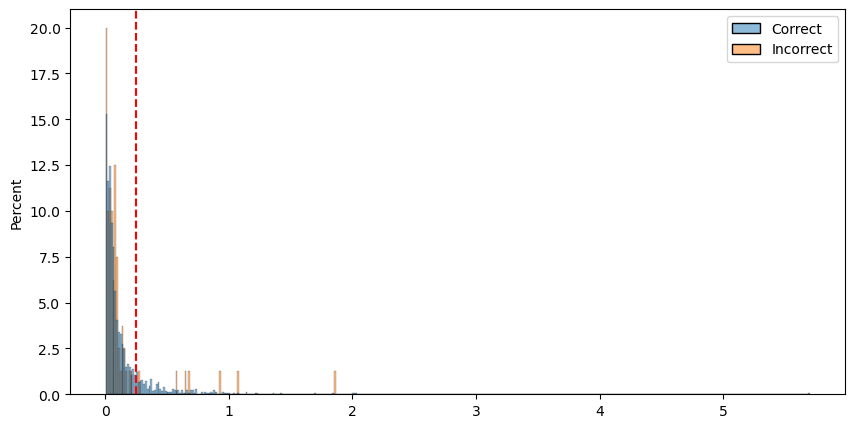

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize=(10, 5))

sns.histplot({"Correct": mse_error_correct.numpy(), "Incorrect": mse_error_incorrect.numpy()},
             multiple="layer", common_norm=False, stat="percent", ax=ax)
ax.axvline(th, color='red', linestyle='--', label="Threshold")
plt.show()

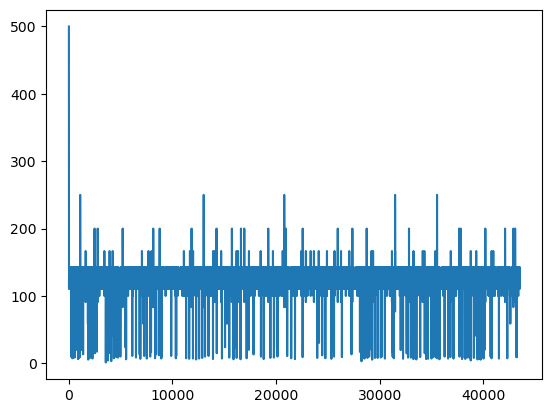

Median 125.0
Mean 120.2092058392301
Min TDiff 2
Median TDiff 8.0
Max TDiff 802


In [ ]:
import matplotlib.pyplot as plt

gaze120 = recs["Pat047"]["nod"]["Gaze120"]
t = gaze120.loc[gaze120.Message=="gaze sample", "System Timestamp"].to_numpy()
tDiff = np.diff(t)
fps = 1/(tDiff*0.001)
fps = fps[np.where(~np.isinf(fps))]
plt.plot(fps)
plt.show()
print("Median", np.median(fps))
print("Mean", np.mean(fps))
print("Min TDiff", tDiff.min())
print("Median TDiff", np.median(tDiff))
print("Max TDiff", tDiff.max())

# Angle velocity

In [16]:
display(gaze)
display(scene)

,Timestamp,System Timestamp,Device Timestamp,Message,Message Type,Object Name,isValid,Local Gaze Origin X,Local Gaze Origin Y,Local Gaze Origin Z,...,Right World Gaze Origin Z,Right World Gaze Direction X,Right World Gaze Direction Y,Right World Gaze Direction Z,Right Eye Openness,Right Eye Pupil Diameter,Right Eye Pupil Position X,Right Eye Pupil Position Y,Unnamed: 53,Event
0,63865375149250,1729771149250,881371177,gaze sample,gs,-1,True,0.002667,0.003058,-0.035012,...,-0.002357,0.830061,-0.356264,-0.429017,1.000000,2.221329,0.528157,0.541638,NaN,Fixation_0
1,63865375149263,1729771149263,881371185,gaze sample,gs,-1,True,0.002157,0.003052,-0.034999,...,-0.002685,0.832203,-0.352372,-0.428091,1.000000,2.202026,0.527968,0.541988,NaN,Fixation_0
2,63865375149292,1729771149292,881371219,gaze sample,gs,-1,True,-0.008480,0.002988,-0.034700,...,-0.002897,0.835340,-0.345758,-0.427366,1.000000,2.177048,0.527752,0.542592,NaN,Fixation_0
3,63865375149299,1729771149299,881371227,gaze sample,gs,-1,True,-0.009778,0.002982,-0.034665,...,-0.002972,0.835572,-0.344222,-0.428153,1.000000,2.182419,0.527834,0.542713,NaN,Fixation_0
4,63865375149307,1729771149307,881371235,gaze sample,gs,-1,True,-0.010428,0.002977,-0.034646,...,-0.002988,0.835979,-0.341457,-0.429569,1.000000,2.186417,0.527968,0.542758,NaN,Fixation_0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58660,63865375857350,1729771857350,882079265,gaze sample,gs,-1,True,0.001595,0.003804,-0.035777,...,-0.015866,0.931781,-0.038649,0.360906,0.926026,2.650421,0.329879,0.513288,NaN,Saccade
58661,63865375857361,1729771857361,882079282,gaze sample,gs,-1,True,0.009315,0.003752,-0.035952,...,-0.015603,0.933672,-0.046462,0.355065,0.911695,2.647324,0.333617,0.512871,NaN,Saccade
58662,63865375857373,1729771857373,882079290,gaze sample,gs,-1,True,0.000771,0.003781,-0.035679,...,-0.015418,0.924547,-0.036433,0.379291,0.912256,2.779312,0.339732,0.514374,NaN,Saccade
58663,63865375857384,1729771857384,882079299,gaze sample,gs,-1,True,-0.009939,0.003880,-0.035345,...,-0.015072,0.944876,-0.038021,0.325186,0.956970,2.585373,0.349610,0.514469,NaN,Saccade


,Timestamp,EyeDataTimestamp,Main CameraPosX,Main CameraPosY,Main CameraPosZ,Main CameraForwardX,Main CameraForwardY,Main CameraForwardZ,Main CameraRotX,Main CameraRotY,...,robot5TargetForwardZ,robot5TargetRotX,robot5TargetRotY,robot5TargetRotZ,robot5TargetRotW,robot5TargetMT,FixatedObject,Round,Points,Msg
31145,1361.041,1729771495246,-0.272299,1.615670,-0.029323,0.341788,-0.244384,-0.907446,0.078596,0.973419,...,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,False,Wall4,9,0,StartGame
31146,1361.053,1729771495257,-0.272746,1.615628,-0.029783,0.347869,-0.243430,-0.905389,0.079734,0.972799,...,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,False,robot2,9,0,NaN
31147,1361.063,1729771495268,-0.273238,1.615503,-0.030273,0.354224,-0.242854,-0.903077,0.080933,0.972105,...,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,False,robot2,9,0,NaN
31148,1361.074,1729771495279,-0.273603,1.615265,-0.030759,0.360630,-0.242685,-0.900583,0.081993,0.971375,...,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,False,robot2,9,0,NaN
31149,1361.086,1729771495290,-0.273999,1.615035,-0.031325,0.367047,-0.242490,-0.898040,0.083018,0.970633,...,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,False,robot2,9,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63747,1723.146,1729771857350,-0.295454,1.627136,0.006904,0.994496,-0.047308,-0.093487,-0.069985,-0.736101,...,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,False,Wall4,18,131,NaN
63748,1723.157,1729771857361,-0.294336,1.626956,0.008054,0.996399,-0.042397,-0.073425,-0.067258,-0.729513,...,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,False,Wall4,18,131,NaN
63749,1723.168,1729771857373,-0.293193,1.626942,0.009243,0.997932,-0.037425,-0.052253,-0.064315,-0.722489,...,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,False,Wall4,18,131,NaN
63750,1723.179,1729771857384,-0.292155,1.627146,0.010330,0.999040,-0.031936,-0.029986,-0.061088,-0.715025,...,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,False,Wall4,18,131,NaN


In [ ]:
from tqdm import tqdm
import utils
save=False
savepath = "Data/Dataset_Prepare"

time_before = 200
time_after = 200
fps = 90
n_before = int(time_before/1000*fps)
n_after = int(time_after/1000*fps)
frame_count = n_before + n_after + 1

cond = "headAndGaze"
rec = recs["Pat021"]

# counter = dict()
# for rec in recs:
    # counter[rec.name] = dict()
    # for cond in Recording.conditions:
# counter[rec.name][cond] = 0

myFilter = None

res = dict()
for cond in Recording.conditions:
    features = {"Correct": list(), "Incorrect": list()}
    pat_name = {"Correct": list(), "Incorrect": list()}
    for rec in tqdm(recs):
        final_rounds = rec.get_final_rounds(cond).Round.to_numpy()
        gaze = rec[cond]["Gaze"] if fps==90 else rec[cond]["Gaze120"]

        if myFilter is not None:
            gaze[["Local Gaze Direction %s" % x for x in ["X", "Y", "Z"]]] = myFilter(gaze[["Local Gaze Direction %s" % x for x in ["X", "Y", "Z"]]].to_numpy())

        scene = rec[cond]["SceneData"]
        scene = scene.loc[scene.Round.isin(final_rounds)]
        scene_infos = scene.loc[scene.Msg.astype(str).apply(lambda x: "target selected" in x), ["Msg", "EyeDataTimestamp"]]
        gaze_timestamps = gaze["System Timestamp"].to_numpy()
        i = 0
        for _, row in scene_infos.iterrows():
            msg = row["Msg"]
            kind = "Correct" if "Correct" in msg else "Incorrect"
            # idx = gaze.loc[(gaze["System Timestamp"] == row["EyeDataTimestamp"])].index[0]
            idx = np.searchsorted(gaze_timestamps, row["EyeDataTimestamp"], side="left")
            start_idx = idx - n_before
            end_idx = idx + n_after
            gaze_use = gaze.loc[start_idx:end_idx]
            gvs = gaze_use[["Local Gaze Direction %s" % x for x in ["X", "Y", "Z"]]].to_numpy()
            t = gaze_use["System Timestamp"].to_numpy()
            frame_count = len(gvs)
            # angles_rec = [utils.angle_between(np.array([0, 0, 1]), x) for x in gvs[:83]]
            features_rec = [utils.angle_between(x, y)/((t1-t0)/1000) for x, y, t0, t1 in zip(gvs[:(frame_count-1)], gvs[1:frame_count], t[:(frame_count-1)], t[1:frame_count])]
            features[kind].append(features_rec)
            pat_name[kind].append(rec.name)
    if save:
        for k in ["Correct", "Incorrect"]:
            a = np.array(features[k])
            p = np.array(pat_name[k])
            np.save(os.path.join(savepath, f"anglesVel_fps{fps}_{cond}_{k}_b{time_before}_a{time_after}_finalRounds.npy"), a)
            np.save(os.path.join(savepath, f"namesVel_fps{fps}_{cond}_{k}_b{time_before}_a{time_after}_finalRounds.npy"), p)
    else:
        res[cond] = {"Features": {k: np.array(features[k]) for k in ["Correct", "Incorrect"]}, "Names": {k: np.array(pat_name[k]) for k in ["Correct", "Incorrect"]}}
    


100%|██████████| 52/52 [01:40<00:00,  1.92s/it]


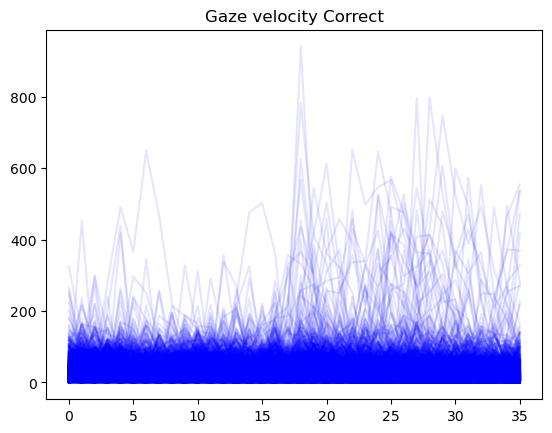

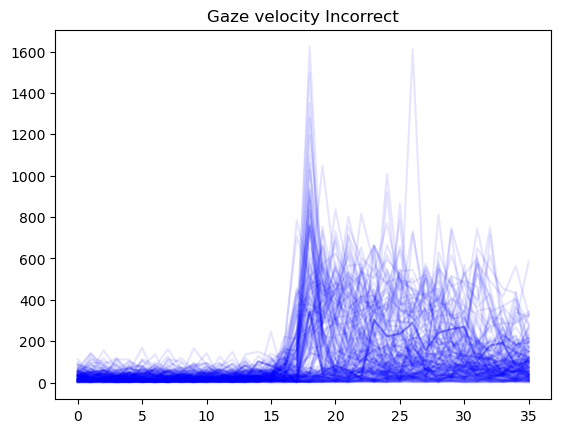

In [20]:
import matplotlib.pyplot as plt


res["gaze"]["Features"]["Correct"].shape
for k in ["Correct", "Incorrect"]:
    for angle_vel in res["gaze"]["Features"][k]:
        plt.plot(angle_vel, alpha=0.1, color="blue")
    plt.title(f"Gaze velocity {k}")
    plt.show()